Over / Under with Nested Models

    - Last time, we explored the calibration of the individual team runs scored models

    - We observed some degree of mis-calibration: over-predicting the probability of low runs scored, under-predicting the probability of high runs scored

    - However, these discrepancies did not seem large enough to explain the high degree of miscalibration in the overall model

    - Concluded that the independence assumption must be flawed

    - In this notebook, we use nested modeling to predict the total runs scored

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import structureboost as stb
import ml_insights as mli
import scipy as sp

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [1]:
# How unlikely is it that we would get 197 (or fewer) successes in 344 trials if the success probability is .7?

.7*(197+147)

240.79999999999998

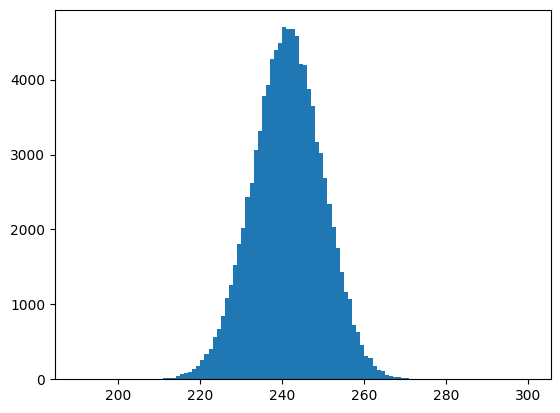

In [4]:
plt.hist(np.random.binomial(n=(197+147), p=.7, size=100000), bins=np.linspace(190,300,111));

In [5]:
df = pd.read_csv('df_bp9.csv', low_memory=False)

df_runs = pd.read_csv('df_runs_bp11.csv', low_memory=False)

In [6]:
df.over_under_line.max()

15.0

In [7]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],16)

Nested Modeling

    - Idea: use the outputs of one model as the inputs to a second model

    - Want to use the predicted distributions (and the over / under line) to predict probability of over / under (rather than relying on the independence assumption)

    - Problem: If we use our previous runs scored model and apply it to the training data, the predictions will be overconfident (or otherwise weird)

    - Need predicted distributions on the training set that are "credible" (i.e. predictions from a model that did not see that point in the training set)

    - We will use cross-validation to get these values.

    - We will create folds based on time.

In [8]:
fold_dict = {}
fold_dict[1901]=-1
for i in range(1902,2018,5):
    fold_dict[i]=0
for i in range(1903,2018,5):
    fold_dict[i]=1
for i in range(1904,2018,5):
    fold_dict[i]=2
for i in range(1905,2018,5):
    fold_dict[i]=3
for i in range(1906,2018,5):
    fold_dict[i]=4
fold_dict[2018] = 5 # validation set
for i in range(2018,2023):
    fold_dict[i]=6 # test set
df_runs['foldnum1'] = df_runs.season.apply(lambda x: fold_dict[x])

In [9]:
pd.crosstab(df_runs.season, df_runs.foldnum1)

foldnum1,-1,0,1,2,3,4,6
season,,,,,,,
1901,4,0,0,0,0,0,0
1914,0,0,0,4,0,0,0
1915,0,0,0,0,4,0,0
1922,0,2,0,0,0,0,0
1923,0,0,2,0,0,0,0
1924,0,0,0,2,0,0,0
1925,0,0,0,0,12,0,0
1926,0,0,0,0,0,4,0
1927,0,6,0,0,0,0,0


In [10]:
df_runs.shape

(264256, 159)

In [11]:
df_runs.iloc[:5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
0,1901,19010531,0,190105310,MLA,WS1,AL,AL,0.0,NaN,MIL04,D,3,0.291209,0.348485,0.380952,0.729437,103.0,56.0,-30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.714286,1.142857,0.007519,0.270677,0.312030,3.571429,0.845865,3.628571,1.285714,0.078095,0.307095,0.362619,3.947657,0.986914,4.360000,1.400000,0.143111,0.340644,0.409222,4.248640,1.062160,1.5,0.20,0.370000,0.4500,1.500000,0.200000,0.370000,0.450000,1.500000,0.200000,0.370000,0.450000,1,3,-1
1,1901,19010625,0,190106250,WS1,MLA,AL,AL,0.0,NaN,WAS07,D,3,0.285987,0.337754,0.384175,0.721930,76.0,46.0,-30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.250000,1.402778,0.015444,0.389961,NaN,6.444444,1.791506,2.780952,1.3952

In [31]:
df_runs.iloc[132128:132133,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
132128,1901,19010531,0,190105310,MLA,WS1,AL,AL,0.0,NaN,MIL04,D,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.903846,1.230769,0.015464,0.329897,0.572165,6.826923,1.829897,3.466667,1.366667,0.114762,0.351476,0.506429,5.658438,1.414610,4.284444,1.437778,0.160222,0.361356,0.476333,5.047004,1.261751,1.5,0.200000,0.370000,0.450000,1.5,0.200000,0.370000,0.450000,1.5,0.200000,0.370000,0.450000,0,3,-1
132129,1901,19010625,0,190106250,WS1,MLA,AL,AL,0.0,NaN,WAS07,D,1,0.244000,0.286119,0.320000,0.606119,76.0,43.0,-30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.145228,1.419087,0.014599,0.416058,NaN,7.070539,2.072993,3.437888,1.304348,0.026190,0.36416

In [13]:
df_train = df_runs[(df_runs.season>1901) & (df_runs.season<=2000)]
df_valid = df_runs[(df_runs.season>=2001) & (df_runs.season<=2018)]
df_test = df_runs[df_runs.season>=2019]

df_test_game = df[df.season>=2019]

In [14]:
df_train.shape, df_valid.shape, df_test.shape

((160450, 159), (87444, 159), (16358, 159))

In [15]:
df_train.shape[0] /2,  df_valid.shape[0]/2, df_test.shape[0]/2

(80225.0, 43722.0, 8179.0)

In [16]:
df_train.iloc[:5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
2,1914,19140603,0,191406030,SLF,IND,FL,FL,0.0,NaN,STL08,D,6,0.267592,0.340179,0.355798,0.695976,59.0,27.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.366667,1.450000,0.080000,0.405500,0.559167,5.683733,1.420933,4.819048,1.485714,0.165714,0.380143,0.481190,4.846781,1.211695,4.915556,1.493333,0.184000,0.374733,0.464556,4.668231,1.167058,1.5,0.20,0.370000,0.450000,1.500000,0.200000,0.370000,0.450000,1.500000,0.200000,0.370000,0.450000,1,6,2
3,1914,19140714,0,191407140,CHF,SLF,FL,FL,0.0,NaN,CHI11,D,11,0.259182,0.321806,0.367261,0.689067,50.0,33.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.250000,1.500000,0.024390,0.585366,NaN,8.979167,3.504065,3.028571,1.57142

In [33]:
df_train.iloc[80225:80225+5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
132130,1914,19140603,0,191406030,SLF,IND,FL,FL,0.0,NaN,STL08,D,9,0.289885,0.343931,0.389990,0.733920,61.0,50.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.203390,1.610169,0.040609,0.482234,NaN,7.644068,2.289340,3.990476,1.561905,0.125238,0.422643,NaN,6.271924,1.567981,4.528889,1.528889,0.165111,0.394567,NaN,5.333298,1.333324,1.5,0.20,0.370000,0.450000,1.5,0.200000,0.370000,0.45000,1.5,0.200,0.370000,0.450000,0,9,2
132131,1914,19140714,0,191407140,CHF,SLF,FL,FL,0.0,NaN,CHI11,D,0,0.239239,0.297597,0.323323,0.620920,58.0,27.0,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.285714,0.948052,0.062762,0.305439,NaN,3.129870,1.008368,1.749206,1.090476,0.112857,0.351405,

In [34]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_35',
 'Strt_TB_BB_perc_35',
 'Strt_H_BB_perc_35',
 'Strt_SO_perc_10',
 'Bpen_WHIP_75',
 'Bpen_TB_BB_perc_75',
 'Bpen_H_BB_perc_75',
 'Bpen_SO_perc_75',
 'Bpen_WHIP_35',
 'Bpen_TB_BB_perc_35',
 'Bpen_H_BB_perc_35',
 'Bpen_SO_perc_35',
 'Bpen_WHIP_10',
 'Bpen_TB_BB_perc_10',
 'Bpen_H_BB_perc_10',
 'Bpen_SO_perc_10',
 'lineup9_OBP_162',
 'lineup9_SLG_162',
 'home_hitting']

In [35]:
bpv2 = np.linspace(-.5,16.5,18)
bpv2

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5])

In [36]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

Now, we will do "nested" prediction to create the run distribution values

In [37]:
run_dist_train = np.zeros((df_train.shape[0], 17))

In [22]:
# Loop to get cross-validated predictions on the training set

model_list = []
preds_list = []
for fn in range(5):
    tr_mask = df_train.foldnum1!=fn
    te_mask = df_train.foldnum1==fn
    X_tr = df_train.loc[tr_mask,feat_set]
    X_te = df_train.loc[te_mask,feat_set]
    y_tr = df_train[target][tr_mask]
    y_te = df_train[target][te_mask]
    model_list.append(stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2))
    model_list[fn].fit(X_tr, y_tr, eval_set=(X_te, y_te), early_stop_past_steps=5, eval_freq=10)
    run_dist_train[te_mask,:] = model_list[fn].predict_distributions(X_te).probmat

i=0, eval_set_loss = 2.4128834525491136
i=10, eval_set_loss = 2.4084096738911365
i=20, eval_set_loss = 2.405041059713994
i=30, eval_set_loss = 2.4025565262334974
i=40, eval_set_loss = 2.400549591544095
i=50, eval_set_loss = 2.3990451605600263
i=60, eval_set_loss = 2.3978543355166466
i=70, eval_set_loss = 2.3969376328373455
i=80, eval_set_loss = 2.3960577234804186
i=90, eval_set_loss = 2.395345395670694
i=100, eval_set_loss = 2.3947798921335584
i=110, eval_set_loss = 2.3943015842877102
i=120, eval_set_loss = 2.393938639602886
i=130, eval_set_loss = 2.393627232403456
i=140, eval_set_loss = 2.3933485696017582
i=150, eval_set_loss = 2.393173748185537
i=160, eval_set_loss = 2.392989850901724
i=170, eval_set_loss = 2.3928288188621303
i=180, eval_set_loss = 2.392724226824268
i=190, eval_set_loss = 2.3926349888066234
i=200, eval_set_loss = 2.3925344003220976
i=210, eval_set_loss = 2.392491001991172
i=220, eval_set_loss = 2.392446889469145
i=230, eval_set_loss = 2.3923793151858153
i=240, eval_s

In [23]:
# Redo previous approach to get predictions on valid, test sets

cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', structured_loss=False,
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)


i=0, eval_set_loss = 2.4533637115920217
i=10, eval_set_loss = 2.449040969415463
i=20, eval_set_loss = 2.445733019041689
i=30, eval_set_loss = 2.443203356501198
i=40, eval_set_loss = 2.4414834612713747
i=50, eval_set_loss = 2.4402189060863164
i=60, eval_set_loss = 2.4393306323465946
i=70, eval_set_loss = 2.4384929875451884
i=80, eval_set_loss = 2.437908425264655
i=90, eval_set_loss = 2.4372158030776636
i=100, eval_set_loss = 2.4368213129083416
i=110, eval_set_loss = 2.4364704318490786
i=120, eval_set_loss = 2.4362536213916144
i=130, eval_set_loss = 2.436070877762828
i=140, eval_set_loss = 2.435915176639284
i=150, eval_set_loss = 2.435809445620755
i=160, eval_set_loss = 2.435743241029265
i=170, eval_set_loss = 2.4357204168203617
i=180, eval_set_loss = 2.435676382127313
i=190, eval_set_loss = 2.4356446134202283
i=200, eval_set_loss = 2.4356461338593705
i=210, eval_set_loss = 2.4356643551057013
i=220, eval_set_loss = 2.4356628992587255
i=230, eval_set_loss = 2.43572156634226
i=240, eval_se

In [24]:
run_dist_valid = cr1.predict_distributions(X_valid).probmat
run_dist_test = cr1.predict_distributions(X_test).probmat

In [25]:
cr1.predict_distributions(X_test).log_loss(y_test)

2.4515974861130263

In [26]:
run_cdf_train = np.cumsum(run_dist_train, axis=1)[:,:-1]
run_cdf_valid = np.cumsum(run_dist_valid, axis=1)[:,:-1]
run_cdf_test = np.cumsum(run_dist_test, axis=1)[:,:-1]

In [27]:
result_probs = np.array([run_dist_train[i,y_train[i]] for i in range(len(y_train))])

In [28]:
-np.mean(np.log(result_probs))

2.402028907129007

In [39]:
run_cdf_train1 = run_cdf_train[:80225,:]
run_cdf_train2 = run_cdf_train[80225:,:]
run_cdf_valid1 = run_cdf_valid[:43722,:]
run_cdf_valid2 = run_cdf_valid[43722:,:]
run_cdf_test1 = run_cdf_test[:8179,:]
run_cdf_test2 = run_cdf_test[8179:,:]

run_train_team1 = y_train[:80225]
run_train_team2 = y_train[80225:]
run_valid_team1 = y_valid[:43722]
run_valid_team2 = y_valid[43722:]
run_test_team1 = y_test[:8179]
run_test_team2 = y_test[8179:]

run_total_train = run_train_team1 + run_train_team2
run_total_valid = run_valid_team1 + run_valid_team2
run_total_test = run_test_team1 + run_test_team2

run_total_train = np.minimum(run_total_train, 16)
run_total_valid = np.minimum(run_total_valid, 16)
run_total_test = np.minimum(run_total_test, 16)

base_cols = ['rd'+str(i) for i in range(16)]
cn1 = [cn+'_h' for cn in base_cols]
cn2 = [cn+'_v' for cn in base_cols]
cn_list = cn1+cn2

In [40]:
X_train_nested = pd.DataFrame(np.hstack((run_cdf_train1, run_cdf_train2)))
X_valid_nested = pd.DataFrame(np.hstack((run_cdf_valid1, run_cdf_valid2)))
X_test_nested = pd.DataFrame(np.hstack((run_cdf_test1, run_cdf_test2)))

X_train_nested.columns = cn1+cn2
X_valid_nested.columns = cn1+cn2
X_test_nested.columns = cn1+cn2

In [41]:
run_cdf_train1.shape, run_cdf_train2.shape, X_train_nested.shape

((80225, 16), (80225, 16), (80225, 32))

In [42]:
X_train_nested.sample(10)

,rd0_h,rd1_h,rd2_h,rd3_h,rd4_h,rd5_h,rd6_h,rd7_h,rd8_h,rd9_h,rd10_h,rd11_h,rd12_h,rd13_h,rd14_h,rd15_h,rd0_v,rd1_v,rd2_v,rd3_v,rd4_v,rd5_v,rd6_v,rd7_v,rd8_v,rd9_v,rd10_v,rd11_v,rd12_v,rd13_v,rd14_v,rd15_v
59006,0.042068,0.124925,0.240933,0.379765,0.519648,0.642041,0.744531,0.823426,0.881459,0.921258,0.949650,0.968238,0.981029,0.988948,0.993482,0.996159,0.083007,0.216998,0.373551,0.528600,0.653827,0.755654,0.826300,0.879811,0.916147,0.942905,0.964299,0.977359,0.986905,0.992152,0.995182,0.996970
25603,0.079551,0.208071,0.362790,0.515974,0.647162,0.752039,0.832225,0.889199,0.929504,0.955221,0.972681,0.983239,0.990600,0.994817,0.997133,0.998378,0.065417,0.174830,0.311032,0.466771,0.603099,0.722704,0.810203,0.875255,0.920535,0.949815,0.968341,0.980649,0.988302,0.992941,0.995799,0.997473
64524,0.073214,0.192930,0.343247,0.496976,0.634272,0.744824,0.828375,0.888410,0.928647,0.955390,0.972402,0.983114,0.990087,0.994256,0.996691,0.998085,0.072972,0.194489,0.344575,0.492316,0.622601,0.731079,0.815072,0.874969,0.918924,0.947064,0.967323,0.979383,0.987715,0.992592,0.995649,0.997258
458,0.045185,0.125027,0.235406,0.367646,0.496822,0.623638,0.730034,0.812916,0.876276,0.918965,0.946776,0.965634,0.977637,0.985757,0.990872,0.994378,0.059353,0.162510,0.295226,0.435117,0.566975,0.680901,0.774592,0.845881,0.899002,0.934657,0.958914,0.973994,0.984155,0.990190,0.993996,0.996525
12031,0.042419,0.124349,0.239186,0.368086,0.507775,0.623609,0.725836,0.807653,0.866451,0.910773,0.944173,0.966337,0.979818,0.988180,0.992729,0.995671,0.070268,0.186728,0.327764,0.474477,0.606099,0.717739,0.804198,0.869521,0.914029,0.944895,0.965436,0.978053,0.986754,0.991783,0.995232,0.997031
30492,0.072277,0.189025,0.337433,0.495895,0.634009,0.747959,0.831503,0.892144,0.931298,0.956942,0.973246,0.983428,0.989804,0.994039,0.996439,0.997909,0.052816,0.149077,0.273476,0.411810,0.547214,0.666289,0.763946,0.839912,0.891897,0.928879,0.954382,0.970737,0.982206,0.988778,0.993426,0.996051
67612,0.073435,0.191829,0.341741,0.499739,0.637420,0.745958,0.828846,0.889288,0.930557,0.956655,0.973381,0.984125,0.990779,0.994788,0.997191,0.998426,0.057666,0.157336,0.284135,0.418970,0.545591,0.664767,0.758457,0.831162,0.885296,0.924853,0.951342,0.968341,0.980556,0.987881,0.992242,0.995387
20104,0.057302,0.159475,0.294689,0.443369,0.583168,0.704216,0.798278,0.868316,0.915364,0.946581,0.967219,0.979498,0.987605,0.992707,0.995704,0.997609,0.098245,0.246295,0.414455,0.580678,0.711130,0.807685,0.874381,0.920181,0.950311,0.969413,0.981753,0.988944,0.993371,0.996325,0.997804,0.998783
72071,0.066345,0.184291,0.331613,0.480330,0.613753,0.724188,0.809404,0.871619,0.915274,0.945021,0.965975,0.979681,0.988158,0.993624,0.996367,0.997761,0.104285,0.254435,0.424239,0.580866,0.702355,0.793680,0.859461,0.907553,0.941512,0.963186,0.978330,0.987013,0.992417,0.995758,0.997506,0.998448
75717,0.061751,0.172572,0.313033,0.463762,0.598870,0.717329,0.806868,0.872208,0.917536,0.947521,0.968173,0.980112,0.988446,0.993243,0.995934,0.997692,0.041595,0.120405,0.229298,0.354462,0.475042,0.591199,0.687590,0.767664,0.831455,0.878329,0.915001,0.943409,0.962076,0.975773,0.984829,0.990377
